In [211]:
import numpy as np
import pandas as pd
#from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot
import panel as pn
#pn.extension('plotly')
import plotly.express as px
import pandas as pd
#import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [125]:
## Reading share data
shares = pd.read_csv(r"C:\Users\aelri\Desktop\Fintech-1\Resources\shares.csv",index_col="Date",infer_datetime_format=True, parse_dates=True)
shares.head()

portfolio_weights=np.array([0.33,0.33,0.34])

In [126]:
## Percentage Change
percent_change=shares.pct_change()
percent_change

,google,nvda,amazon
Date,,,
2016-09-29,NaN,NaN,NaN
2016-09-30,0.002942,0.016617,0.009963
2016-10-03,-0.006085,-0.001022,-0.000681
2016-10-04,0.005009,-0.002191,-0.003239
2016-10-05,0.000051,-0.001025,0.012386
...,...,...,...
2021-09-22,0.009252,0.032712,0.010892
2021-09-23,0.006301,0.024657,0.010636
2021-09-24,0.005686,-0.017837,0.002787


In [127]:
percent_change.dropna(inplace=True)
percent_change

,google,nvda,amazon
Date,,,
2016-09-30,0.002942,0.016617,0.009963
2016-10-03,-0.006085,-0.001022,-0.000681
2016-10-04,0.005009,-0.002191,-0.003239
2016-10-05,0.000051,-0.001025,0.012386
2016-10-06,0.000502,-0.013044,-0.003198
...,...,...,...
2021-09-22,0.009252,0.032712,0.010892
2021-09-23,0.006301,0.024657,0.010636
2021-09-24,0.005686,-0.017837,0.002787


In [128]:
## Annulised variance
portfolio_covariance=percent_change.cov()*252
portfolio_covariance

,google,nvda,amazon
google,0.071702,0.072616,0.052702
nvda,0.072616,0.231423,0.077523
amazon,0.052702,0.077523,0.086577


In [129]:
## portfolio variance
portfolio_variance=np.dot(portfolio_weights.T,np.dot(portfolio_covariance,portfolio_weights))
portfolio_variance

0.08805706756637122

In [130]:
## portfolio standard deviation
port_volatility=np.sqrt(portfolio_variance)
port_volatility

0.2967441112581195

In [131]:
## Caluclate annual portfolio return
portfolio_return=np.sum(percent_change.mean()* portfolio_weights)*252
portfolio_return

0.40926010386123846

In [132]:
## Expected annual return ,volatility and variance
percent_var= str(round(portfolio_variance,2) * 100) + "%"
percent_vol=str(round(port_volatility,2) * 100) + "%"
percent_return=str(round(portfolio_return,2)* 100) + "%"

print ("Expected Annual Return: "+ percent_return)
print("Expected Volatilty: "+ percent_vol)
print("Expected Variance: "+ percent_var)

Expected Annual Return: 41.0%
Expected Volatilty: 30.0%
Expected Variance: 9.0%


In [133]:
pip install pyportfolioopt


In [134]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [135]:
## Portfolio optimisation
## Calculate expected returns and the annualised covariance of asset returns
mean=expected_returns.mean_historical_return(shares)
a=risk_models.sample_cov(shares)

# Optimise the Sharpe ratio
eff_front=EfficientFrontier(mean,a)
weights=eff_front.max_sharpe()
cleaned_weights=eff_front.clean_weights()
print(cleaned_weights)
eff_front.portfolio_performance(verbose=True)


OrderedDict([('google', 0.18173), ('nvda', 0.5444), ('amazon', 0.27387)])
Expected annual return: 49.8%
Annual volatility: 34.7%
Sharpe Ratio: 1.38


(0.498164795270972, 0.34667009081625205, 1.3793079009069087)

In [215]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices=get_latest_prices(shares)
weights=cleaned_weights
da= DiscreteAllocation(weights,latest_prices,total_portfolio_value= 10000)

allocation,leftover =da.lp_portfolio()
print("Discrete Allocation ", allocation)
print('Funds Remaining '. format(leftover))


NameError: Solver GLPK_MI is not installed. 

In [168]:
port_returns=[]
port_weights=[]
port_vol=[]
num_assets=len(shares.columns)
num_port= 5000
shares.reset_index().set_index('Date') 
individual_return=shares.resample('Y').last().pct_change().mean()

In [169]:
for portfolio in range(num_port):
    weights=np.random.random(num_assets)
    weights=weights/np.sum(weights)
    port_weights.append(weights)
    returns=np.dot(weights,individual_return)
    port_returns.append(returns)
    #var=np.dot(weights.T,np.dot(portfolio_covariance,weights))
    #sd=np.sqrt(var)
    #print(sd)
    var=portfolio_covariance.mul(weights,axis=0).mul(weights, axis=1).sum().sum()
    sd=np.sqrt(var)
   # print(sd)
    #annualised_sd=sd*np.sqrt(252)
    port_vol.append(sd)


In [170]:
newdata={"Returns": port_returns,"Volatility": port_vol}

for counter,symbol in enumerate(shares.columns.tolist()):
    newdata[symbol+"weight"]=[w[counter] for w in port_weights]
df = pd.DataFrame.from_dict(newdata, orient='index')

In [178]:
revised_portfolio=pd.DataFrame(df)
revised_portfolio.head()
revised_portfolio.T.dropna()
revised_portfolio=revised_portfolio.T.dropna()
##revised_portfolio['Returns'] = [float(x) for x in revised_portfolio['Returns']]
##revised_portfolio['Volatility'] = [float(x) for x in revised_portfolio['Volatility']]
##revised_portfolio["Volatility"] = pd.to_numeric(revised_portfolio["Volatility"], downcast="float")
revised_portfolio

,Returns,Volatility,googleweight,nvdaweight,amazonweight
0,0.408572,0.283196,0.342960,0.250167,0.406872
1,0.360761,0.262616,0.538282,0.112594,0.349125
2,0.484719,0.337810,0.150579,0.503211,0.346210
3,0.445082,0.306639,0.247397,0.370541,0.382062
4,0.359315,0.265430,0.639830,0.135773,0.224397
...,...,...,...,...,...
4995,0.388754,0.290249,0.031506,0.080954,0.887540
4996,0.469397,0.323593,0.072848,0.419004,0.508148
4997,0.467016,0.337927,0.444822,0.515715,0.039464
4998,0.541190,0.390554,0.034037,0.698336,0.267627


Text(0, 0.5, 'Expected Returns')

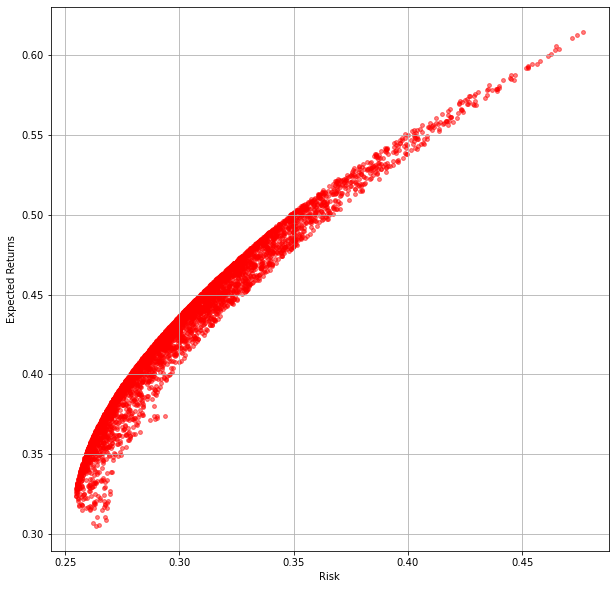

In [181]:
revised_portfolio.plot.scatter(x='Volatility',y='Returns',marker="o",c="red",s=15,alpha=0.5,grid=True,figsize=[10,10])
plt.xlabel("Risk")
plt.ylabel("Expected Returns")

In [182]:
##Minimum Volatility Portfolio
min_vol_port=revised_portfolio.iloc[revised_portfolio["Volatility"].idxmin()]
min_vol_port

Returns         0.326011
Volatility      0.254713
googleweight    0.636808
nvdaweight      0.000184
amazonweight    0.363008
Name: 417, dtype: float64

In [180]:
## Optimal Risky Portfolio
rf=0
optimal_risky_Portfolio=revised_portfolio.iloc[((revised_portfolio['Returns']-rf)/revised_portfolio["Volatility"]).idxmax()]
optimal_risky_Portfolio

Returns         0.442272
Volatility      0.303831
googleweight    0.172971
nvdaweight      0.337896
amazonweight    0.489133
Name: 2492, dtype: float64

Text(0, 0.5, 'Expected Returns')

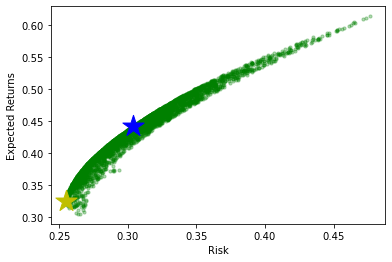

In [199]:
## plotting the optimal portfolio and minimum volatility
plt.scatter(revised_portfolio["Volatility"], revised_portfolio["Returns"],marker='o', s = 10,alpha = 0.3, c ="green")
plt.scatter(min_vol_port[1],min_vol_port[0],c="y",marker="*",s=500)
plt.scatter(optimal_risky_Portfolio[1],optimal_risky_Portfolio[0],c="b",marker="*",s=500)
plt.xlabel("Risk")
plt.ylabel("Expected Returns")

In [214]:
optimal_risky_Portfolio.hvplot.scatter(x="Volatility",y="Returns",by="Returns",legend="top", height=400, width =400)

AttributeError: 'Series' object has no attribute 'hvplot'